In [1]:
import cvxpy as cvx
import ipopt
import numpy as np
import matplotlib.pyplot as plt
plt.rc("text", usetex=True)
%matplotlib inline

## DCP with CVXPy

Model problem is [compressed sensing](https://www.raeng.org.uk/publications/other/candes-presentation-frontiers-of-engineering)

\begin{align*}
& \min_x \|x\|_1\\
\text{s.t. } & Ax = b,
\end{align*}
где $A \in \mathbb{R}^{m \times n}$ и $n \gg m$

### Data generation

In [2]:
n = 1000
m = 10
x_true = np.random.randn(n)
x_true[np.abs(x_true) > 0.05] = 0
print("Num of nnz in x = {}".format(np.sum(x_true != 0)))
A = np.random.randn(m, n)
b = A.dot(x_true)

Num of nnz in x = 40


### [CVXPy](http://www.cvxpy.org/index.html) 

In [ ]:
x = cvx.Variable(n)
objective = cvx.norm1(x)
constr = [A*x == b]
problem = cvx.Problem(cvx.Minimize(objective), constr) 
problem.solve(verbose=True, solver=cvx.GLPK_MI)

### Check solution

In [41]:
tol= 1e-3
print(np.linalg.norm(A.dot(x.value) - b))
print(np.linalg.norm(A[:, np.abs(x.value) > tol].dot(x.value[np.abs(x.value) > tol]) - b))
print(np.linalg.norm(x_true - x.value))
print("Num nnz = {}".format(np.sum(np.abs(x.value) > tol)))

2.7722884960939376e-08
0.004187849122993125
0.22239645909962202
Num nnz = 10


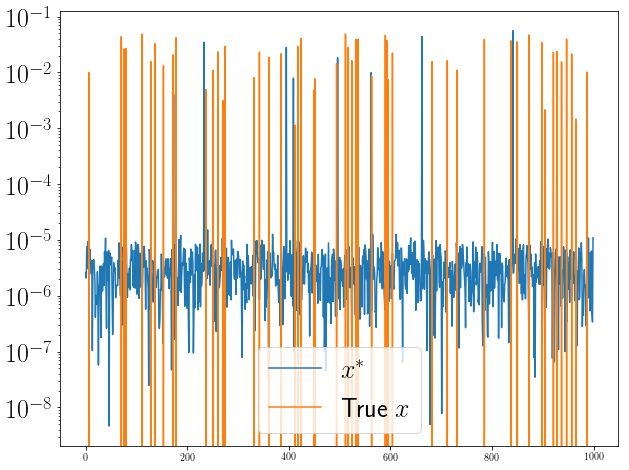

In [39]:
plt.figure(figsize=(10, 8))
plt.plot(np.abs(x.value), label=r"$x^*$")
plt.plot(np.abs(x_true), label=r"True $x$")
plt.legend(fontsize=26)
plt.yticks(fontsize=26)
plt.yscale("log")

(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 <a list of 8 Text xticklabel objects>)

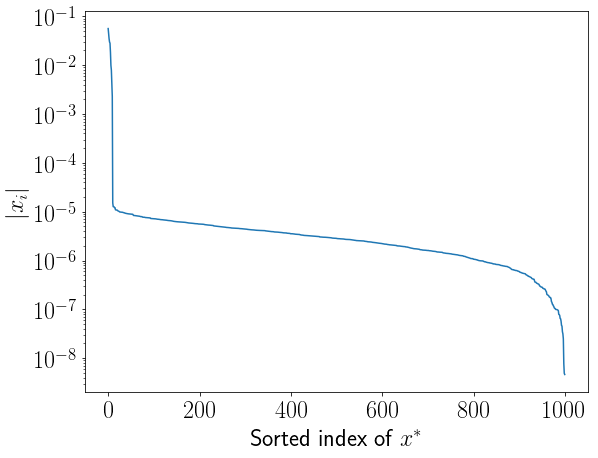

In [40]:
plt.figure(figsize=(9, 7))
plt.semilogy(np.sort(np.abs(x.value))[::-1])
plt.ylabel("$|x_i|$", fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel(r"Sorted index of $x^*$", fontsize=24)
plt.xticks(fontsize=24)

### Check DCP

In [6]:
# Non-affine equality constraint
y = cvx.Variable(1)
obj = cvx.Minimize(cvx.power(y, 3))
problem = cvx.Problem(obj, [cvx.power(y-3, 2) == 0])
problem.solve(verbose=True, solver="SCS")
print(y.value)

DCPError: Problem does not follow DCP rules. Specifically:
The following constraints are not DCP:
power(var159 + -3.0, 2) == 0.0 , because the following subexpressions are not:
|--  power(var159 + -3.0, 2) == 0.0

In [9]:
# Non-convex objective function 
y = cvx.Variable(2)
obj = cvx.Minimize(y[0]**2 - y[1]**2)
problem = cvx.Problem(obj)
problem.solve(verbose=True)

DCPError: Problem does not follow DCP rules. Specifically:
The objective is not DCP. Its following subexpressions are not:
power(var219[0], 2) + -power(var219[1], 2)

## General purpose IPOPT

#### Smooth problem similar to the problem in part 1

\begin{align*}
& \min_x \|x\|^2_2\\
\text{s.t. } & Ax = b,
\end{align*}
где $A \in \mathbb{R}^{m \times n}$ и $n \gg m$

In [10]:
f = lambda x: x @ x
constr = {"fun": lambda x: A.dot(x) - b, 
          "jac": lambda x: A,
          "type": "eq"}
res = ipopt.minimize_ipopt(f, jac=lambda x: 2 * x, x0=np.zeros(n),
                           constraints=constr, )

In [11]:
print(np.linalg.norm(A.dot(res.info["x"]) - b))
res.info["status_msg"]

7.015235463629862e-16


b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'

#### Non-smooth problem from part 1

\begin{align*}
& \min_x \|x\|_1\\
\text{s.t. } & Ax = b,
\end{align*}
где $A \in \mathbb{R}^{m \times n}$ и $n \gg m$

In [12]:
f = lambda x: np.linalg.norm(x, 1)
constr = {"fun": lambda x: A.dot(x) - b, 
          "jac": lambda x: A,
          "type": "eq"}
res = ipopt.minimize_ipopt(f, jac=lambda x: np.sign(x),
                           x0=np.zeros(n), constraints=constr)

In [13]:
print(np.linalg.norm(A.dot(res.info["x"]) - b))
res.info["status_msg"]

1.3315627116480466e-16


b"Restoration phase failed, algorithm doesn't know how to proceed."